In [2]:
%matplotlib inline
import pylab
import numpy as np

In [284]:
class AdaptiveControl(object):
    def __init__(self, n_inputs, n_outputs, n_neurons, seed=None, learning_rate_shift=10):
        self.rng = np.random.RandomState(seed=seed)
        self.compute_encoders(n_inputs, n_neurons)
        self.initialize_decoders(n_neurons, n_outputs)
        self.learning_rate_shift=learning_rate_shift
        
        self.state = np.zeros(n_neurons, dtype='int64')
        
        
    def step(self, state, error):
        # feed input over the static synapses
        current = self.compute_neuron_input(state)
        # do the neural nonlinearity
        activity = self.neuron(current)
        # apply the learned synapses        
        value = self.compute_output(activity)
        
        # update the synapses with the learning rule
        index = np.where(activity>0)
        self.decoder[:,index] -= error >> self.learning_rate_shift
        
        return value
    
    def compute_encoders(self, n_inputs, n_neurons):
        # generate the static synapses
        # NOTE: this algorithm could be changed, and just needs to produce a similar
        # distribution of connection weights.  Changing this distribution slightly
        # changes the class of functions the neural network will be good at learning
        max_rates = self.rng.uniform(0.5, 1, n_neurons)
        intercepts = self.rng.uniform(-1, 1, n_neurons)
        
        gain = max_rates / (1 - intercepts)
        bias = -intercepts * gain        
        
        enc = self.rng.randn(n_neurons, n_inputs)
        enc /= np.linalg.norm(enc, axis=1)[:,None]
        
        encoder = enc * gain[:, None]
        self.bias = (bias*(1<<16)).astype('int32')
        
        # store sign and shift rather than the encoder
        self.sign = np.where(encoder>0, 1, -1)
        self.shift1 = np.log2(encoder*(1<<16)*self.sign).astype(int)

                
    def initialize_decoders(self, n_neurons, n_outputs):
        self.decoder = np.zeros((n_outputs, n_neurons))
        
    def compute_neuron_input(self, state):
        # this should be able to be reduced to 32 bits (or even 16)
        result = self.bias.astype('int64')<<16
        for i, s in enumerate(state):
            result = result + (self.sign[:,i]*(s.astype('int64')<<(self.shift1[:,i])))
        return result>>16
        # the above code approximates the following multiply using shifts
        #return np.dot(self.encoder, state) + self.bias
    
    def neuron(self, current):
        self.state = self.state + current
        self.state = np.where(self.state<0, 0, self.state)
        spikes = np.where(self.state>=(1<<16), 1, 0)
        self.state[spikes>0] -= 1<<16
        
        # Alternatively, get rid of the self.state and replace it with an LFSR
        #spikes = np.where(self.rng.randint(0, 1<<16, len(current))<current, 1, 0)
        return spikes
    
    def compute_output(self, activity):
        return np.sum(self.decoder[:,np.where(activity>0)])
    

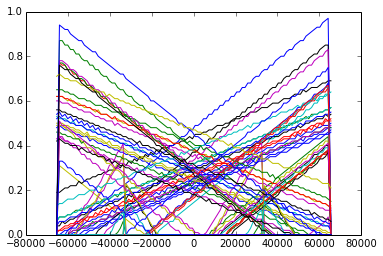

In [286]:
n_neurons = 100
ac = AdaptiveControl(n_inputs=1, n_outputs=1, n_neurons=n_neurons, seed=1)
steps = 100
inputs = np.linspace(-(1<<16), 1<<16, 100).astype('int32')
rates = np.zeros((len(inputs), n_neurons))
for i, input in enumerate(inputs):
    for j in range(steps):
        current = ac.compute_neuron_input(np.array([input]))
        activity = ac.neuron(current)
        rates[i, :] += activity/float(steps)
        
pylab.plot(inputs, rates);

Now let's try teaching the model to just output the identity function (i.e. the output should be the same as the input).  We train it over a sine wave.

In [287]:
n_neurons = 100
ac = AdaptiveControl(n_inputs=1, n_outputs=1, n_neurons=n_neurons, seed=1, learning_rate_shift=10)

inputs = []
outputs = []
errors = []
error = np.zeros(1, dtype='int32')
for i in range(2000):
    input = (np.sin(i*2*np.pi/1000)*0x10000).astype('int32')
    output = ac.step([input], error)
    error[:] = output - input
    inputs.append(input)
    outputs.append(output)
    errors.append(output-input)
    
    
    

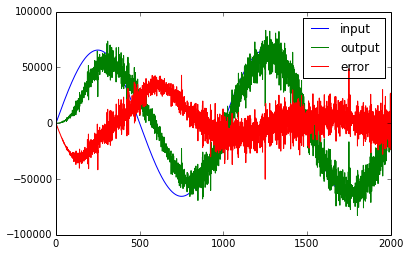

In [288]:
pylab.plot(inputs, label='input')
pylab.plot(outputs, label='output')
pylab.plot(errors, label='error')
pylab.legend(loc='best')
pylab.show()